# Using my own NN implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from visualize import plot_decision_boundary

In [2]:
x_train=pd.read_csv("Logistic_X_Train.csv").values
x_test=pd.read_csv("Logistic_X_Test.csv").values
y_train=pd.read_csv("Logistic_Y_Train.csv").values

x_train.shape,x_test.shape,y_train.shape

((2250, 2), (750, 2), (2250, 1))

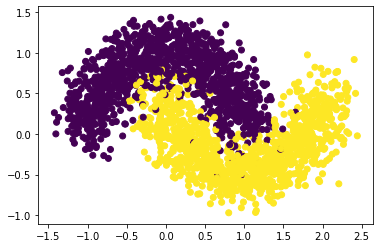

In [3]:
plt.scatter(x_train[:,0],x_train[:,1],c=y_train.flatten())
plt.show()

In [4]:
ohe=OneHotEncoder()
y_train=ohe.fit_transform(y_train.reshape(-1,1)).toarray()
y_train

c:\users\akshay\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [5]:
class NeuralNetwork:
    """Creates a Neural Network and implements forward and backward propagation steps"""
    
    def __init__(self,layers=np.array([1]),n_features=2,learning_rate=0.1,itr=10):
        """layers: type(np.array). Each element corresponds to the no. of units in that layer.
                   No. of layers is given by the size of the list. 
                   (default=[1],means 1 layer with 1 unit(logistic regression))
           n_features=No. of features for each example (no. of inputs for the first hidden layer of the network)
           learning_rate=(0.1 default)
           itr: No. of iteration of Forward+Backward Propagation that are to be run (default=10)
        """
        
        self.layers=layers
        self.inputs=n_features
        self.itr=itr
        self.lr=learning_rate
        
        ################################### Initializing Weights & Biases for all Layers ###################################
        
        self.weights=[]                         
        self.biases=[]
        
        current_inputs=self.inputs
        
        for l in range(self.layers.shape[0]):
            wl=[]                                     #weights for layer l
            bl=[]                                     #biases for layer l
            for j in range(self.layers[l]):           #for each unit(j) in layer l
                
                wlj=(np.random.randn(current_inputs))*(2/current_inputs)**0.5   #weights for unit(j) in layer l
                blj=(np.random.randn())*(2/current_inputs)**0.5                 #bias for unit j in layer l (a scalar)
                
                wl.append(wlj)
                bl.append(blj)
                
            self.weights.append(np.array(wl))         #appending the weights of layer l to list of all weights
            self.biases.append(np.array(bl))          #appending the biases of layer l to list of all biases
            
            current_inputs=self.layers[l]             #No. of inputs to next layer is the no. of units in current layer
            
        self.weights=np.array(self.weights)           #converting self.weights and self.biases to numpy array
        self.biases=np.array(self.biases)
        
    def loss(self,y,output):
        if y is None:                                 #for test data
            return 0
        return 0.5*np.sum(np.sum((y-output)**2))
    
    def plot_loss(self,loss):
        plt.plot(np.arange(len(loss)),loss)
        plt.xlabel("itr")
        plt.ylabel("loss")
        plt.show()
    
    
    def activation(self,z):
        """Applies activation function to z"""
        return 1/(1+np.e**(-z))
    
    ############################################### Forward Propagation Step ##################################################
        
    def forward_propagation(self,x,y=None):
        """Implements 1 forward propagation Step"""
        a=x                                          #a is the input for current layer
        outputs=[]
        
        for l in range(self.layers.shape[0]):
            w=self.weights[l]
            b=self.biases[l]
            z=np.dot(a,w.T)+b
            a=self.activation(z)
            
            outputs.append(a)
            
        return outputs,self.loss(y,outputs[-1])
        
    ############################################### Backward Propagation Step ##################################################
    
    def backward_propagation(self,x,y,outputs):
        
        ################################################# for output layer ####################################################
        
        a=outputs[-1]                                      #outputs[-1] is the output of last (output) layer
        ap=outputs[-2]                                     #outputs[-1] is the output of the second last (last hidden) layer
        
        grad=[]                                            #grad will be an array of size (L,l) L=no. of units in output layer
                                                           #l=no. of units in last hidden layer
        delta=(a-y)*a*(1-a)                                #a will be of size (m,L) where m is the no. of training examples
                                                           #L is the no. of units in output layer. delta will be an array of
                                                           #size (m,L)
        
        for d in range(delta.shape[0]):                    #for each training example
            
            outd=[]                                        #will be of size (L,l)
            
            for i in delta[d]:                                    
            
                out=[]                                     #will be of size l where l=no. of units in last hidden layer
                for j in ap[d]:                            #ap is the output of the last hidden layer
                    out.append(i*j)  
                outd.append(out)
            grad.append(outd)
            
        grad=np.array(grad)                                #right now, grad is of size (m,L,l)
        grad=np.sum(grad,axis=0)                           #now grad is of size (L,l)
        
        bias_grad=np.sum(delta,axis=0)                     #an array of size L where L is the no. of units in output layer
    
        self.weights[-1]=self.weights[-1]-(self.lr*grad)        #updating the weights of the last layer
        self.biases[-1]=self.biases[-1]-(self.lr*bias_grad)     #updating the biases of the last layer  
        
        ################################################# for hidden layers ##################################################
        
        for h in range(-2,-self.layers.shape[0],-1):
            
            l=self.layers[h]                               #l=no. of units in current layer
        
            #ap is the output of previous layer
            if h==-self.layers.shape[0]:
                ap=x
            else: 
                ap=outputs[h-1]
                
            a=outputs[h]                                   #output of curent layer

            wn=self.weights[h+1]                           #weights of the next layer (size=(no. of units in next layer,l))
            
            delta=np.dot(delta,wn)*a*(1-a)                 #delta for current layer (size=(m,l))
                                                           #(delta to the right of = sign is the delta for the next layer)  
            grad=[]
            
            for d in range(delta.shape[0]):                                    
            
                outd=[]                                        

                for i in delta[d]:                                    

                    out=[]                                     
                    for j in ap[d]:                               
                        out.append(i*j)                        
                    outd.append(out)
                grad.append(outd)

            grad=np.array(grad)                                
            grad=np.sum(grad,axis=0)                           

            bias_grad=np.sum(delta,axis=0)                  
                
            self.weights[h]=self.weights[h]-(self.lr*grad)
            self.biases[h]=self.biases[h]-(self.lr*bias_grad)
            
    def fit(self,x,y):                                 #x,y is the training data
        loss=[]
        
        for i in tqdm(range(self.itr)):
            outputs,l=self.forward_propagation(x,y)
            loss.append(l)
            self.backward_propagation(x,y,outputs)
            
        self.plot_loss(loss)
    
    def predict(self,x):                               #x is the test set
        return np.argmax(self.forward_propagation(x)[0][-1],axis=1)

In [6]:
nn=NeuralNetwork(layers=np.array([20,20,2]),learning_rate=0.001,itr=100)
nn

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


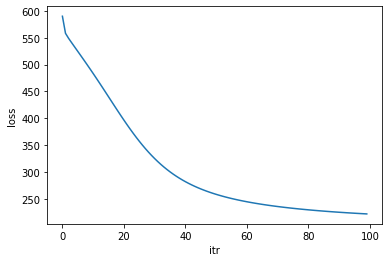

In [7]:
nn.fit(x_train,y_train)

In [8]:
predictions=nn.predict(x_test)
predictions

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,

In [9]:
y_train=np.argmax(y_train,axis=1)
y_train

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

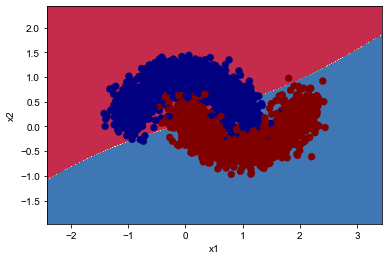

In [10]:
plot_decision_boundary(lambda x_train:nn.predict(x_train),x_train,y_train)

# Using KERAS:

In [11]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [12]:
model=Sequential()
model.add(Dense(20,activation="relu",input_dim=x_train.shape[1]))
model.add(Dense(20,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(5,activation="relu"))
model.add(Dense(3,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 767
Trainable params: 767
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [15]:
x_val=x_train[:250]
y_val=y_train[:250]
x_train_new=x_train[250:]
y_train_new=y_train[250:]

In [16]:
model.fit(x_train_new,y_train_new,batch_size=100,epochs=50,validation_data=(x_val,y_val))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 250 samples
Epoch 1/50
2000/2000 [==============================] - ETA: 34s - loss: 0.6699 - acc: 0.61 - ETA: 0s - loss: 0.6661 - acc: 0.5480 - 2s 1ms/step - loss: 0.6606 - acc: 0.5640 - val_loss: 0.6336 - val_acc: 0.6000
Epoch 2/50
2000/2000 [==============================] - ETA: 0s - loss: 0.6359 - acc: 0.600 - ETA: 0s - loss: 0.6134 - acc: 0.697 - 0s 40us/step - loss: 0.6103 - acc: 0.7070 - val_loss: 0.5853 - val_acc: 0.7760
Epoch 3/50
2000/2000 [==============================] - ETA: 0s - loss: 0.5813 - acc: 0.780 - ETA: 0s - loss: 0.5666 - acc: 0.784 - 0s 38us/step - loss: 0.5679 - acc: 0.7880 - val_loss: 0.5458 - val_acc: 0.8280
Epoch 4/50
2000/2000 [==============================] - ETA: 0s - loss: 0.5752 - acc: 0.800 - ETA: 0s - loss: 0.5382 - acc: 0.815 - 0s 36us/step - loss: 0.5336 - acc: 0.8195 - val_loss: 0.5186 - val_acc: 0.8320
Epoch 5/50
2000/2000 [==============================] - ETA: 

Epoch 39/50
2000/2000 [==============================] - ETA: 0s - loss: 0.2979 - acc: 0.960 - ETA: 0s - loss: 0.2503 - acc: 0.967 - 0s 34us/step - loss: 0.2494 - acc: 0.9680 - val_loss: 0.2551 - val_acc: 0.9560
Epoch 40/50
2000/2000 [==============================] - ETA: 0s - loss: 0.3119 - acc: 0.940 - ETA: 0s - loss: 0.2447 - acc: 0.966 - 0s 36us/step - loss: 0.2466 - acc: 0.9670 - val_loss: 0.2514 - val_acc: 0.9520
Epoch 41/50
2000/2000 [==============================] - ETA: 0s - loss: 0.2790 - acc: 0.970 - ETA: 0s - loss: 0.2417 - acc: 0.970 - 0s 36us/step - loss: 0.2441 - acc: 0.9695 - val_loss: 0.2470 - val_acc: 0.9600
Epoch 42/50
2000/2000 [==============================] - ETA: 0s - loss: 0.2766 - acc: 0.950 - ETA: 0s - loss: 0.2413 - acc: 0.968 - 0s 38us/step - loss: 0.2414 - acc: 0.9675 - val_loss: 0.2451 - val_acc: 0.9600
Epoch 43/50
2000/2000 [==============================] - ETA: 0s - loss: 0.2611 - acc: 0.930 - ETA: 0s - loss: 0.2392 - acc: 0.967 - 0s 34us/step - loss

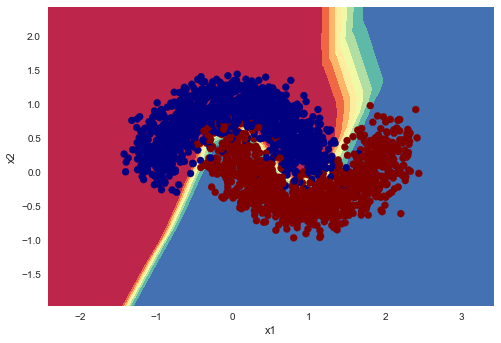

In [17]:
plot_decision_boundary(lambda x_train:model.predict(x_train),x_train,y_train)

In [18]:
predictions=model.predict(x_test).flatten()
predictions=np.round(predictions)
predictions

array([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1.

In [19]:
d={'label':predictions}
df=pd.DataFrame(d)
df.to_csv("moons_predictions.csv",index=False)